In [24]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy


In [3]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

In [4]:
def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

In [5]:
def bce_dice_loss(y_true, y_pred):
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
  return loss

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
images_directory = '/content/gdrive/MyDrive/MINI_DDSM_WITH_MASK/MINI_DDSM/benign/original'

In [8]:
images_to_load = []
for root, directory, file in os.walk(images_directory):
  for f in file:
    images_to_load.append(root + '/' + f)

In [9]:
images_to_load[0]

'/content/gdrive/MyDrive/MINI_DDSM_WITH_MASK/MINI_DDSM/benign/original/402.jpg'

In [10]:
images_directory2 = '/content/gdrive/MyDrive/MINI_DDSM_WITH_MASK/MINI_DDSM/cancer/original'

In [12]:
for root, directory, file in os.walk(images_directory):
  for f in file:
    images_to_load.append(root + '/' + f)

In [11]:
len(images_to_load)

1402

In [12]:
images_train = []
for file in tqdm(sorted(images_to_load[0:round(len(images_to_load)*.8)])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(file, target_size=(512,512))
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    images_train.append(image)



  0%|          | 0/1122 [00:00<?, ?it/s]

In [13]:


images_train = np.array(images_train)

In [14]:
images_test = []
for file in tqdm(sorted(images_to_load[round(len(images_to_load)*.8):])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(file, target_size=(128,128))
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    images_test.append(image)

images_test = np.array(images_test)

  0%|          | 0/280 [00:00<?, ?it/s]

In [15]:
masks_directory = '/content/gdrive/MyDrive/MINI_DDSM_WITH_MASK/MINI_DDSM/benign/mask'

In [16]:
masks_to_load = []
for root, directory, file in os.walk(masks_directory):
  for f in file:
    masks_to_load.append(root + '/' + f)

In [18]:
masks_train = []
for file in tqdm(sorted(masks_to_load[0:round(len(masks_to_load)*.8)])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    mask = tf.keras.preprocessing.image.load_img(file, target_size=(512,512))
    mask = tf.keras.preprocessing.image.img_to_array(mask)/255.0
    masks_train.append(mask)

masks_train = np.array(masks_train)

  0%|          | 0/1122 [00:00<?, ?it/s]

In [19]:
masks_test = []
for file in tqdm(sorted(masks_to_load[round(len(masks_to_load)*.8):])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    mask = tf.keras.preprocessing.image.load_img(file, target_size=(512,512))
    mask = tf.keras.preprocessing.image.img_to_array(mask)/255.0
    masks_test.append(mask)

masks_test = np.array(masks_test)

  0%|          | 0/280 [00:00<?, ?it/s]

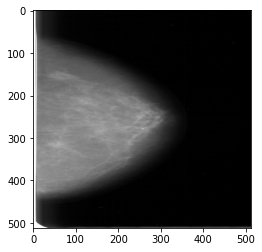

In [20]:
plt.imshow(images_train[0])
plt.show()

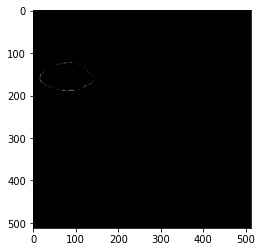

In [21]:
plt.imshow(masks_train[0])
plt.show()

In [22]:
image_width = 512
image_height = 512
image_channels = 3
filter_multiplier = 4
epochs = 100

In [23]:
inputs = Input(shape=(image_width, image_height, image_channels))
#1
first_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(inputs)
first_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(first_convolution)
first_pooling = MaxPooling2D(pool_size=(2,2))(first_convolution)
first_pooling = Dropout(0.5)(first_pooling)

#2
second_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(first_pooling)
second_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(second_convolution)
second_pooling = MaxPooling2D(pool_size=(2,2))(second_convolution)
second_pooling = Dropout(0.5)(second_pooling)

#3
third_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(second_pooling)
third_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(third_convolution)
third_pooling = MaxPooling2D(pool_size=(2,2))(third_convolution)
third_pooling = Dropout(0.5)(third_pooling)

#4
fourth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(third_pooling)
fourth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(fourth_convolution)
fourth_pooling = MaxPooling2D(pool_size=(2,2))(fourth_convolution)
fourth_pooling = Dropout(0.5)(fourth_pooling)

#5
fifth_convolution = Conv2D(filters=16*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(fourth_pooling)
fifth_convolution = Conv2D(filters=16*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(fifth_convolution)

#6
sixth_deconvolution = Conv2DTranspose(filters=8*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(fifth_convolution)
sixth_convolution = concatenate([sixth_deconvolution, fourth_convolution])
sixth_convolution = Dropout(0.5)(sixth_convolution)
sixth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(sixth_convolution)
sixth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(sixth_convolution)


#7
seventh_deconvolution = Conv2DTranspose(filters=4*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(sixth_convolution)
seventh_convolution = concatenate([third_convolution, seventh_deconvolution])
seventh_convolution = Dropout(0.5)(seventh_convolution)
seventh_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(seventh_convolution)
seventh_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(seventh_convolution)

#8
eigth_deconvolution = Conv2DTranspose(filters=2*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(seventh_convolution)
eigth_convolution = concatenate([eigth_deconvolution, second_convolution])
eigth_convolution = Dropout(0.5)(eigth_convolution)
eigth_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(eigth_convolution)
eigth_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(eigth_convolution)

#9
ninth_deconvolution = Conv2DTranspose(filters=1*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(eigth_convolution)
ninth_convolution = concatenate([ninth_deconvolution, first_convolution])
ninth_convolution = Dropout(0.5)(ninth_convolution)
ninth_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(ninth_convolution)
ninth_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(ninth_convolution)

#10
output = Conv2D(filters = 3, kernel_size=(1,1), padding='valid', activation='sigmoid')(ninth_convolution)

In [25]:
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[CategoricalAccuracy()])

In [ ]:
history = model.fit(images_train, masks_train, epochs = epochs, validation_data=(images_test, masks_test))

Epoch 1/100
